# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)
- 24/11/2023:
    - Included loading of document loader cache options
    - [ ] Consider document loader cache options in analysis

---


In [179]:
import os
import json
import git
import re
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-24T18:11:20'

Plot config

In [180]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [181]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


## Input data

In [182]:
records = dict(
    map(
        lambda fpath: (fpath, pd.Series(json.loads(open(fpath, 'r').read()), name=fpath)),
        glob('./reports/profiling/*.json')
    )
)
len(records)

40

In [183]:
s_records = pd.Series(records)
# series with document loader cache options
s_dlco = s_records[s_records.index.str.contains('documentLoaderCacheOptions')]
# series with multi actor reports
s_ma = s_records[s_records.index.str.contains('multiactor')]
# sanity check
assert len(s_dlco) + len(s_ma) == len(records)

In [184]:
def get_df_document_loader_cache_options() -> pd.DataFrame:
    df_dlco = s_dlco.apply(pd.Series).reset_index().rename({'index':'fpath'},axis=1)
    df_dlco['start_report'] = df_dlco.fpath.apply(os.path.basename)\
                                    .apply(lambda bn: re.match(r'\d{13}',bn).group()).astype(int)
    df_dlco.set_index('start_report',inplace=True)
    df_dlco.drop(['fpath'], axis=1, inplace=True)
    df_dlco = df_dlco.stack().apply(pd.Series).unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1).dropna(axis=1, how='all')

    # flatten multilevel index columns
    df_dlco.columns = list(map(lambda t: '_'.join(t), df_dlco.columns))
    return df_dlco

In [185]:
def get_df_multiactor_reports() -> pd.DataFrame:
    series = pd.concat(s_ma.to_dict())
    series.index.get_level_values(0).unique().shape
    df = series.unstack()
    df.index.set_names('fpath',inplace=True)
    df.reset_index(inplace=True)
    df['actor'] = df.fpath.apply(os.path.basename).str.split('-').apply(lambda x: x[0])
    df.index.set_names('idx_report',inplace=True)
    df.rename({'start':'start_report','end':'end_report','delta':'delta_report'},axis=1,inplace=True)
    return df

In [186]:
def get_df() -> pd.DataFrame:
    """ Creates DataFrame containing the multiactor reports and corresponding document loader cache options
    """
    df_ma = get_df_multiactor_reports()
    df_dlco = get_df_document_loader_cache_options()
    assert df_ma.shape[0] == df_dlco.shape[0] # sanity check
    df = get_df_multiactor_reports().merge(get_df_document_loader_cache_options(), on='start_report')
    assert df.shape[0] == df_ma.shape[0] # sanity check
    df.index.set_names('idx_report',inplace=True)
    return df

## Analysis

In [187]:
AGG_FUNCTIONS = ['median','mean', 'std', 'min','max','count',pd.Series.skew, pd.Series.kurt]

---

In [212]:
df = get_df()

### Task-level statistics

In [216]:
df = get_df()
# Expand report records into task-level dataframes
df_tl = df.records\
    .apply(pd.Series)\
    .stack()\
    .apply(pd.Series)\
    .rename({'index':'idx_step', 'tag': 'actorTag', 'name': 'stepName', },axis=1)\
    .reset_index()\
    .rename({'level_0':'idx_report' },axis=1)\
    .drop('level_1',axis=1)\
    .set_index(['idx_report','idx_step'])

# Merge task-level df with initial df
df_tl = df.drop('records',axis=1).merge(df_tl,left_index=True,right_index=True, indicator=True)
assert (df_tl['_merge'] == 'both').all() # sanity check

df_tl['actorStep'] = df_tl.apply(lambda r: f'{r.actorTag}.{r.stepName}',axis=1)

# Add phases
phase_steps = {
    'pre-evaluation': [
        'university.createDiplomaCredential',
        'university.signDiplomaCredential',
        'government.createIdentityCredential',
        'government.signIdentityCredential',
    ],
     'phase-1': [
        'alice.deriveDiplomaCredential',
        'alice.createPresentation01',
        'alice.signPresentation01',
        'recruiter.verifyPresentation01'
    ],
    'phase-2': [
        'alice.deriveIdentityCredential',
        'alice.createPresentation02',
        'alice.signPresentation02',
        'recruiter.verifyPresentation02'
    ],
}
df_phase_steps = pd.Series(phase_steps)\
    .apply(pd.Series)\
    .stack()\
    .to_frame('actorStep')\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename({'level_0': 'phase'}, axis=1)

# sanity check: make sure that actorSteps exactly match
x = set(df_tl.actorStep.value_counts(dropna=False).index)
y = set(df_phase_steps.actorStep.value_counts().index)
assert len(x-y) == 0
df_phase_steps.head(3)

# merge df with phases back to df_tl
df_tl = df_tl.reset_index().merge(df_phase_steps, on='actorStep')
df_tl.set_index(['idx_report','idx_step'],inplace=True)

# sanity check: assert that the same number of samples, for each group!
assert df_tl.groupby(['actorTag','className','actorStep']).count().stack().value_counts(dropna=False).shape[0] == 1

# Add log-transformed delta column
df_tl['delta_log1p'] = df_tl.delta.apply(np.log1p)

df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

In [217]:
display(df_tl.head(3))
df_tl.shape

,,fpath,start_report,end_report,delta_report,actor,DID_cacheResolvedDIDDocs,HTTP_cacheWebResourcesResolvedFromLocalHostInstances,HTTP_cacheWebResourcesResolvedFromTheWeb,stepName,start,end,delta,actorTag,className,_merge,actorStep,phase,delta_log1p
idx_report,idx_step,,,,,,,,,,,,,,,,,,
0,0,./reports/profiling/multiactor-report-17008296...,1700829692018,1700829700834,8816,multiactor,True,False,True,createDiplomaCredential,1700829692018,1700829692019,1,university,DidVCActor,both,university.createDiplomaCredential,pre-evaluation,0.693147
1,0,./reports/profiling/multiactor-report-17008296...,1700829635293,1700829642524,7231,multiactor,True,False,True,createDiplomaCredential,1700829635293,1700829635293,0,university,SolidVCActor,both,university.createDiplomaCredential,pre-evaluation,0.000000
2,0,./reports/profiling/multiactor-report-17008296...,1700829674176,1700829682941,8765,multiactor,True,False,True,createDiplomaCredential,1700829674176,1700829674176,0,university,DidVCActor,both,university.createDiplomaCredential,pre-evaluation,0.000000


(240, 18)

In [218]:
(df_tl.reset_index().groupby('idx_report').count() == 12).all()

idx_step                                                True
fpath                                                   True
start_report                                            True
end_report                                              True
delta_report                                            True
actor                                                   True
DID_cacheResolvedDIDDocs                                True
HTTP_cacheWebResourcesResolvedFromLocalHostInstances    True
HTTP_cacheWebResourcesResolvedFromTheWeb                True
stepName                                                True
start                                                   True
end                                                     True
delta                                                   True
actorTag                                                True
className                                               True
_merge                                                  True
actorStep               

In [219]:
# df_stepname_order is used to specify the order of plots
df_stepname_order = df_tl.reset_index()[['idx_step','stepName','actorTag','actorStep','phase']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
20,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
40,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
60,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
80,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
100,5,createPresentation01,alice,alice.createPresentation01,phase-1
120,6,signPresentation01,alice,alice.signPresentation01,phase-1
140,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
160,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
180,9,createPresentation02,alice,alice.createPresentation02,phase-2


In [238]:
VAR_X = 'delta_log1p'

In [239]:
kwargs_violinplot = dict(
    x=VAR_X,
    y='actorStep',
    hue='className'
)

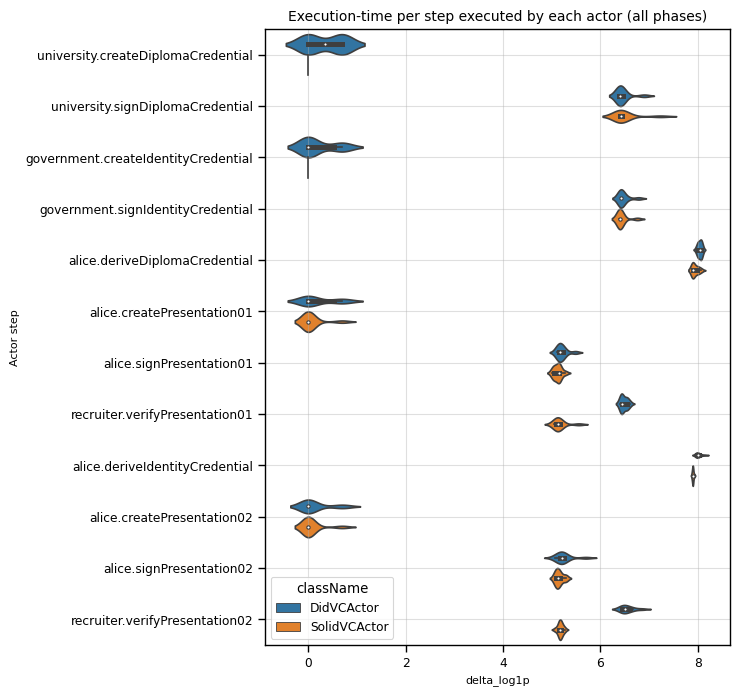

In [240]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = 'Execution-time per step executed by each actor (all phases)'
ax = sns.violinplot(df_tl,
                    **kwargs_violinplot,
                    order=df_stepname_order['actorStep'],
                    tight_layout=True,
                    ax=ax)
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(f'{kwargs_violinplot["x"]}')
ax.grid(alpha=.4)

plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-all-phases.png'),pad_inches=.5)
plt.show()

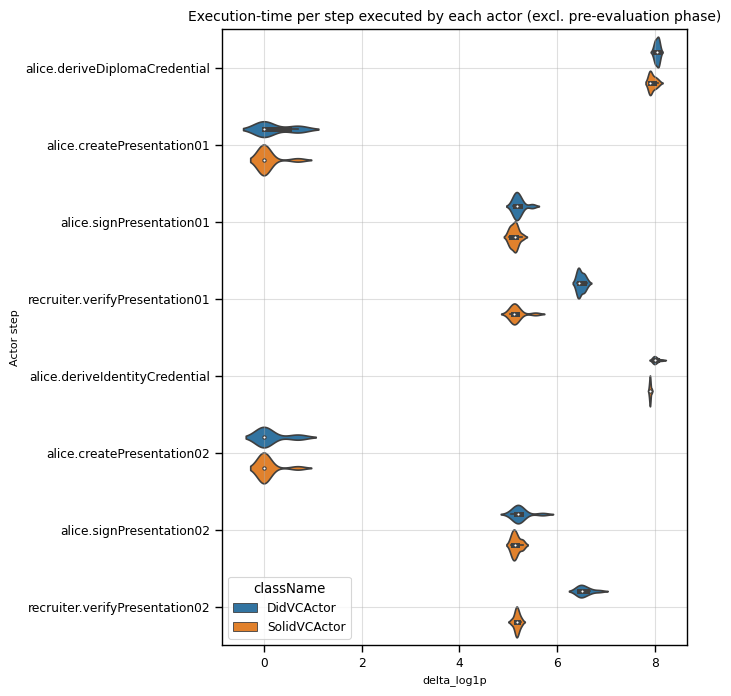

In [263]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = 'Execution-time per step executed by each actor (excl. pre-evaluation phase)'
snsdata = df_tl[df_tl.phase != 'pre-evaluation']
order_data = df_stepname_order[df_stepname_order.phase != 'pre-evaluation']['actorStep']
ax = sns.violinplot(snsdata,
                    **kwargs_violinplot,
                    order=order_data,
                    tight_layout=True,
                    ax=ax,
                   )
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(VAR_X)
ax.grid(alpha=.4)
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-excl-pre-evaluation-phase.png'),pad_inches=.5)
plt.show()

In [242]:
snsdata = df_tl[df_tl.phase != 'pre-evaluation']

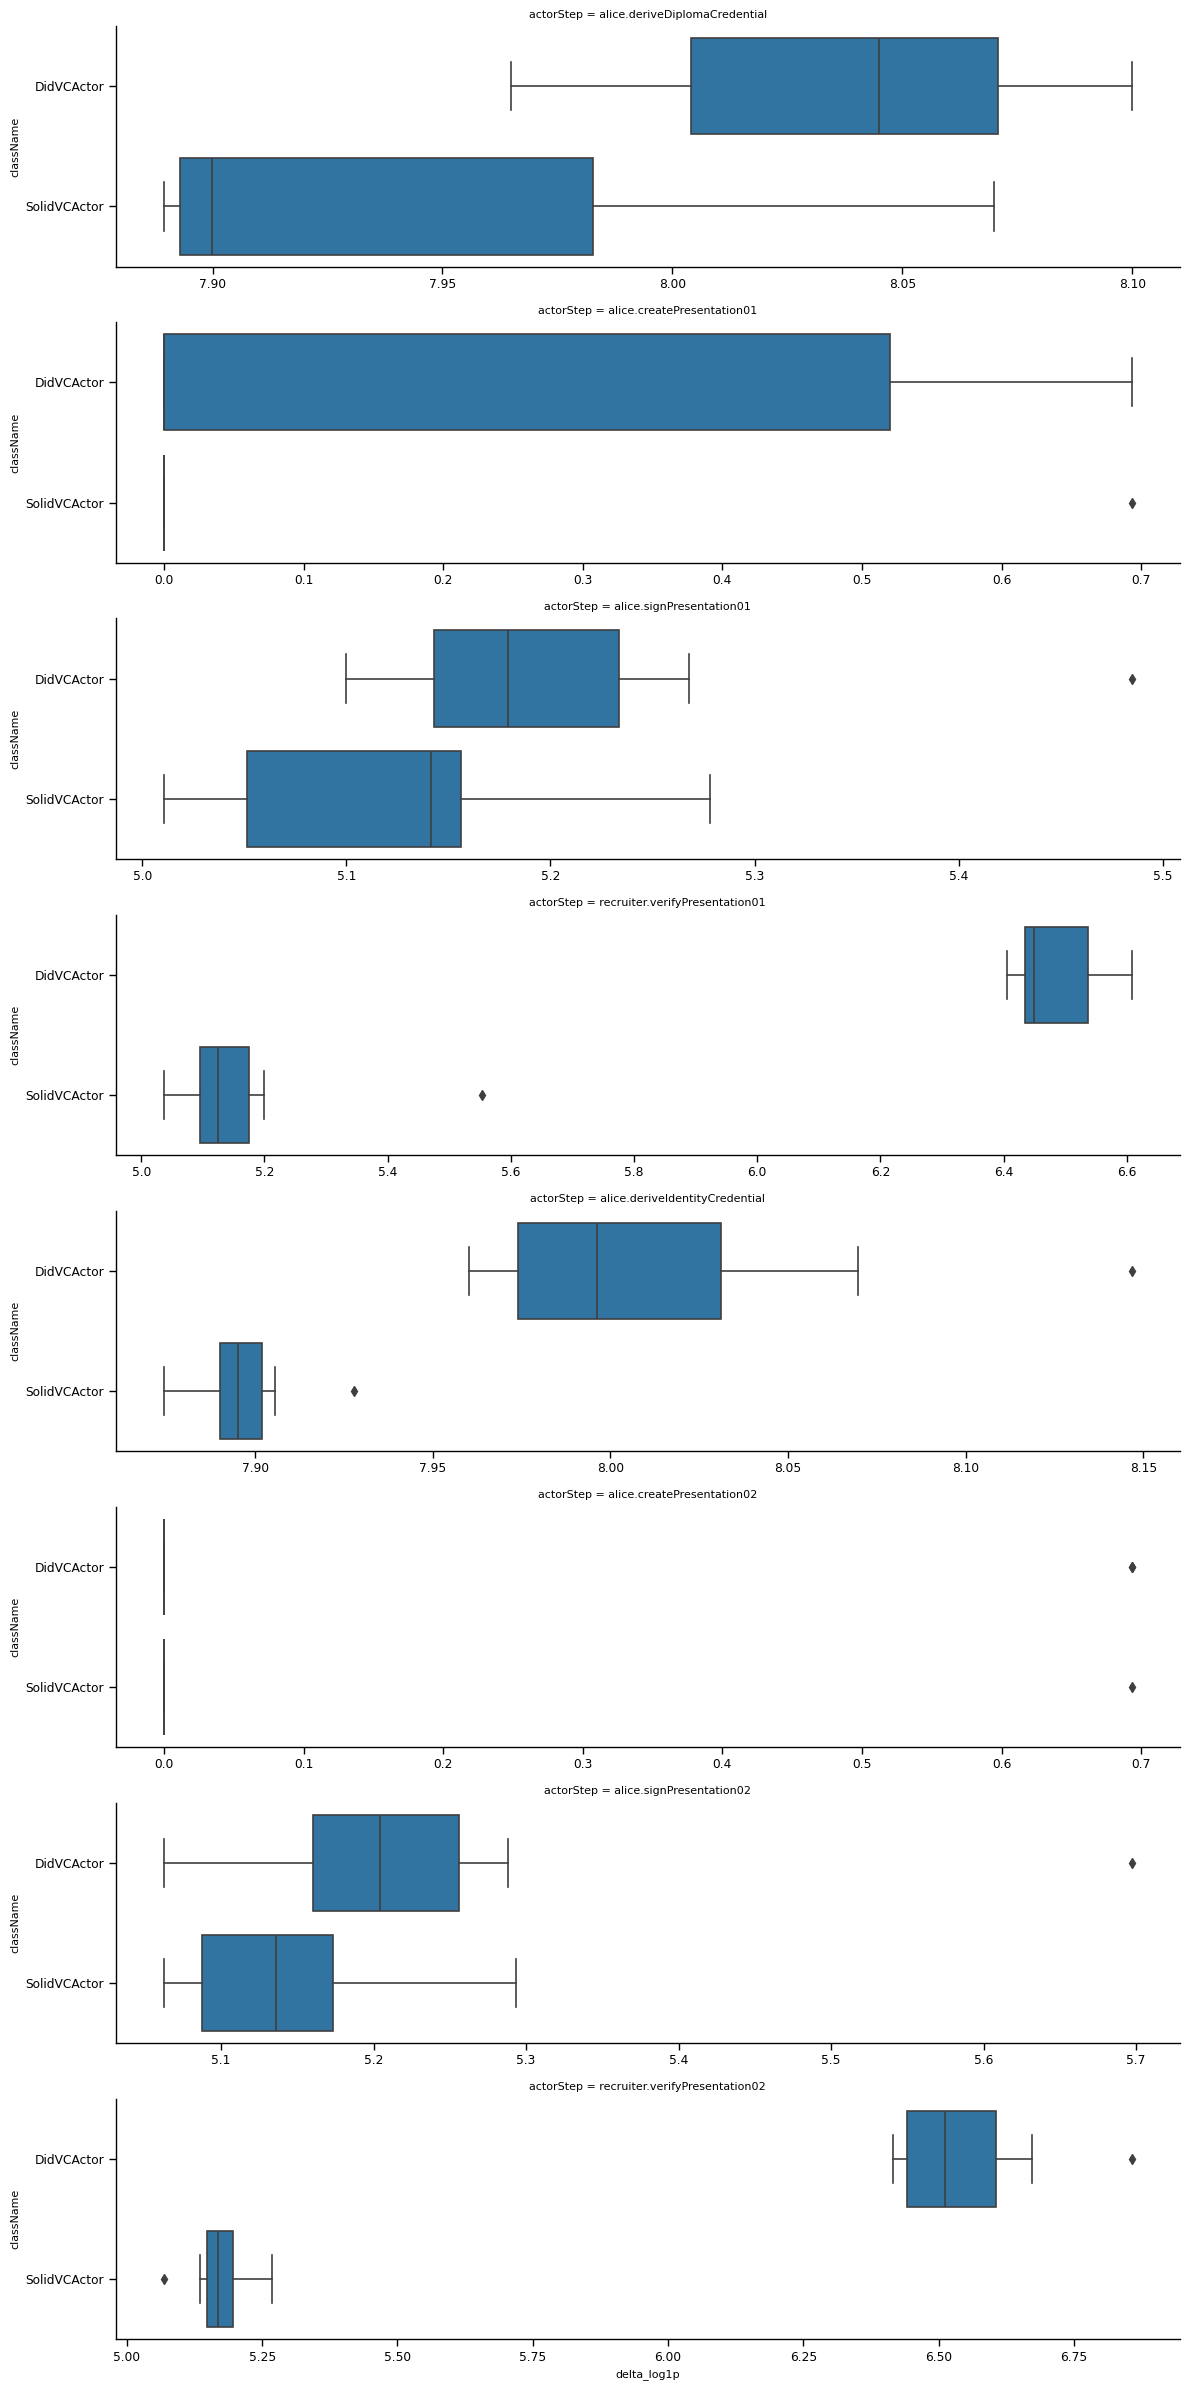

In [243]:
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.boxplot, x=VAR_X, y='className')

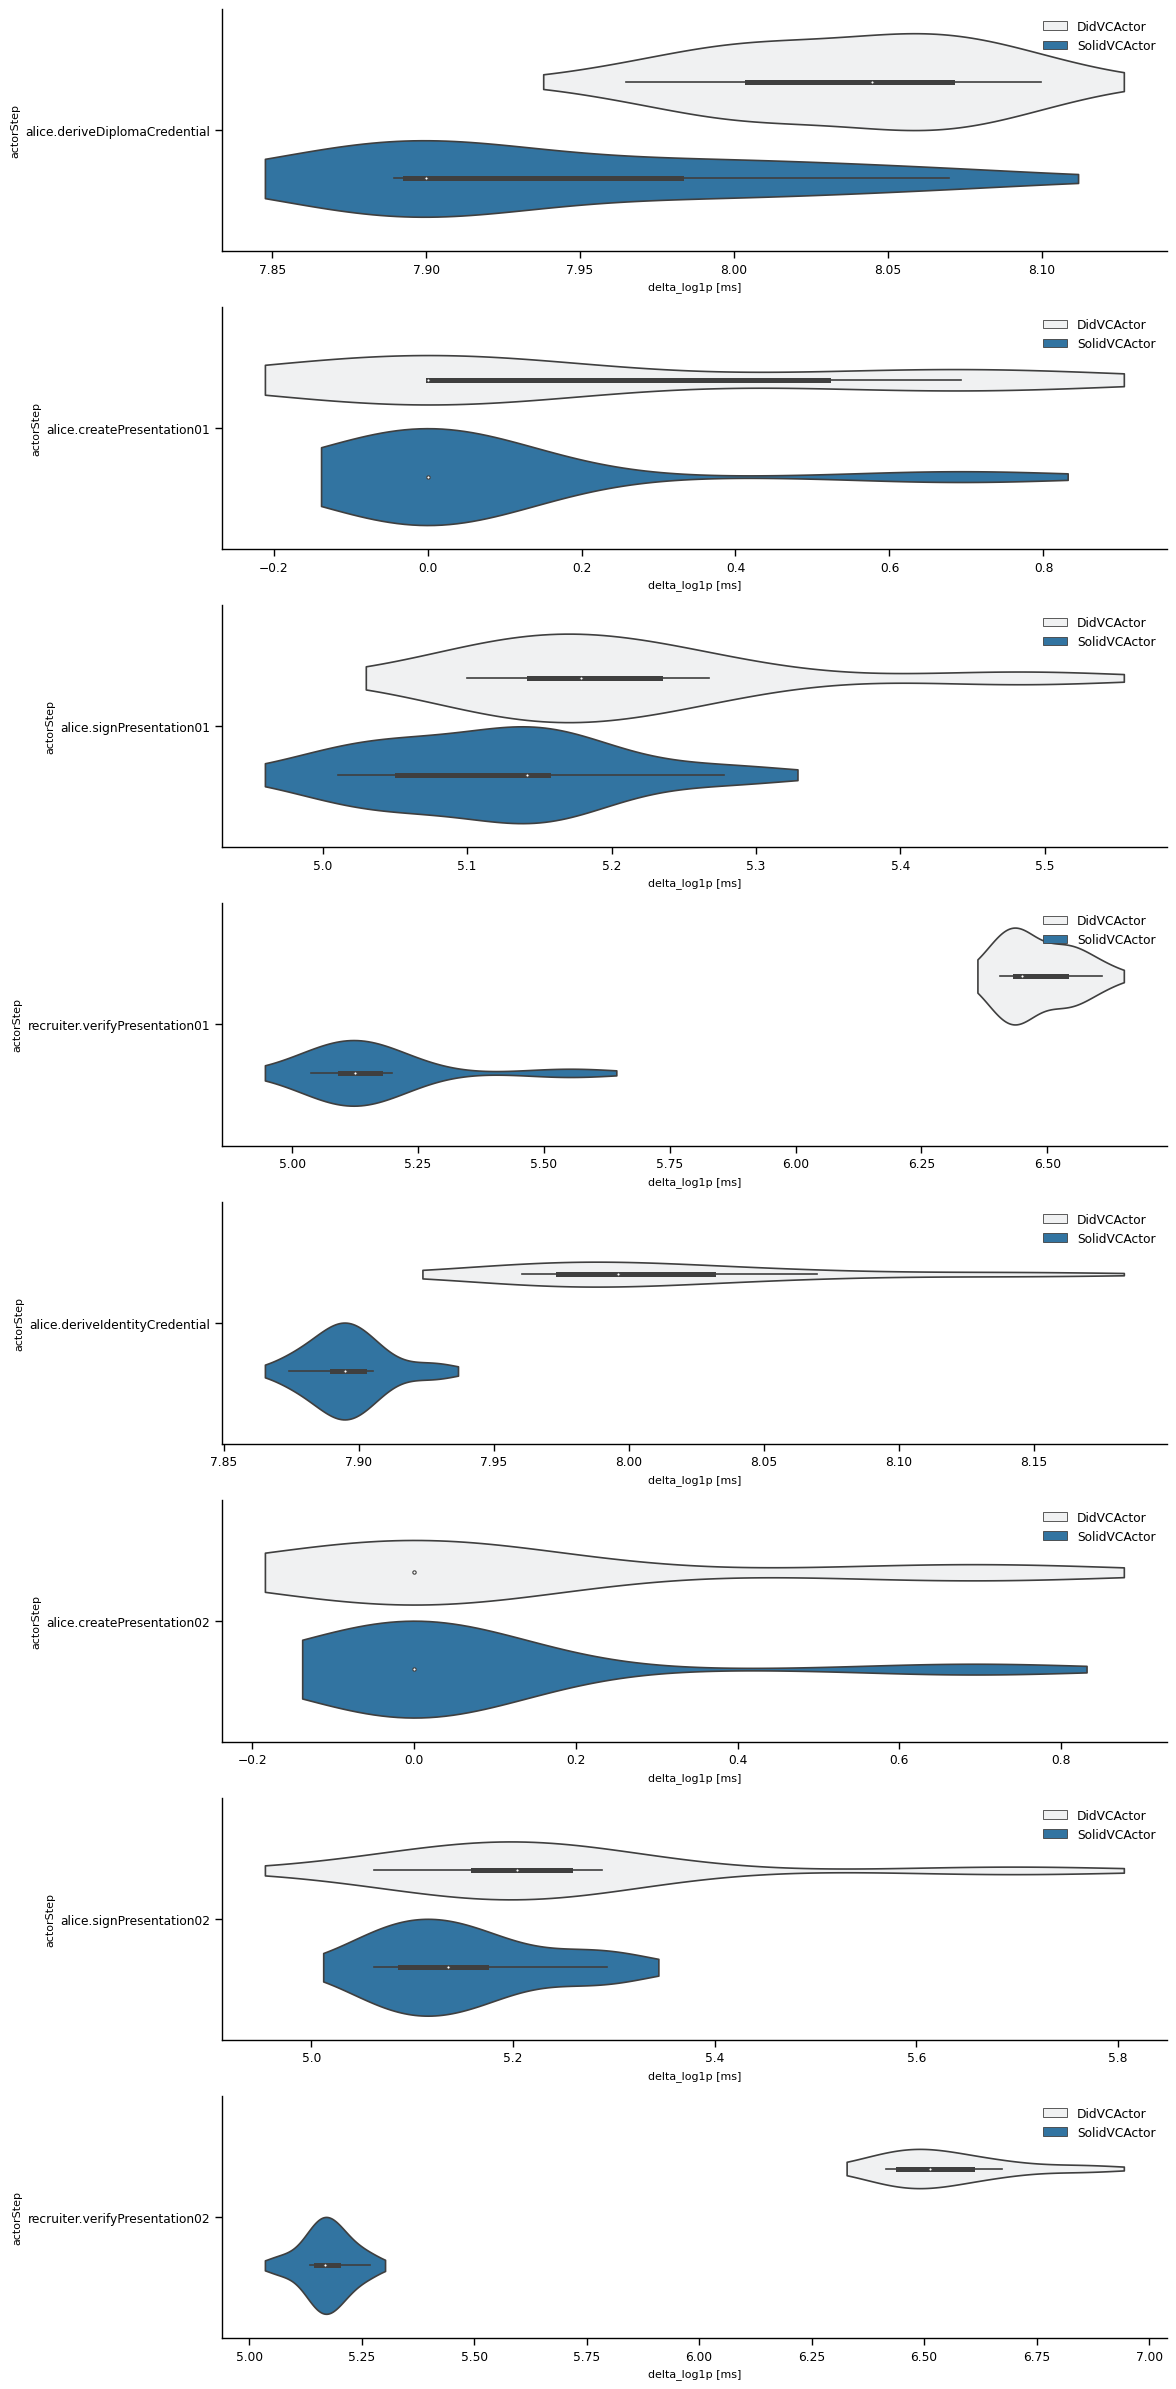

In [244]:
snsdata = df_tl[df_tl.phase != 'pre-evaluation']
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)

g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.violinplot,
                **kwargs_violinplot,
                #inner='point',
                #inner='quart',
#                split='quart',
                cut=1,
                inner_kws=dict(box_width=15, whis_width=2, color=".8")

                
               )
# Create main legend
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    ax.set_title('')
    # Add a copy of the main legend to each subplot
    ax.legend(handles=g.legend.legend_handles,frameon=False)

# Hide main legend
g.legend.set_visible(False)
g.tight_layout()
plt.show()

Compute & export aggregate statistics

In [245]:
# name refers to the function/step name
df_tl_agg = df_tl.groupby(['actorTag','className','stepName'])['delta'].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 8)

In [246]:
df_tl_agg.unstack('className').swaplevel(0,1,axis=1).sort_index(axis=1)

className                           DidVCActor                          \
                                         count      kurt   max    mean   
actorTag   stepName                                                      
alice      createPresentation01             10 -1.224490     1     0.3   
           createPresentation02             10  1.406250     1     0.2   
           deriveDiplomaCredential          10 -0.923988  3293  3096.8   
           deriveIdentityCredential         10  2.649070  3451  3025.2   
           signPresentation01               10  5.557518   240   182.6   
           signPresentation02               10  7.741508   297   191.1   
government createIdentityCredential         10 -1.224490     1     0.3   
           signIdentityCredential           10  7.130982   882   648.7   
recruiter  verifyPresentation01             10 -0.697224   740   652.9   
           verifyPresentation02             10  2.750420   949   702.9   
university createDiplomaCredential          10 -2.571429     1     0.5   
           signDiplomaCredential            10  9.241146   989   645.5   

className                                                                \
                                     median   min      skew         std   
actorTag   stepName                                                       
alice      createPresentation01         0.0     0  1.035098    0.483046   
           createPresentation02         0.0     0  1.778781    0.421637   
           deriveDiplomaCredential   3117.0  2877 -0.209950  131.015521   
           deriveIdentityCredential  2968.5  2864  1.614885  182.406018   
           signPresentation01         176.5   163  2.193820   22.262075   
           signPresentation02         181.0   157  2.645395   38.959951   
government createIdentityCredential     0.0     0  1.035098    0.483046   
           signIdentityCredential     616.0   598  2.640985   86.824280   
recruiter  verifyPresentation01       631.0   604  0.722223   46.417071   
           verifyPresentation02       672.5   610  1.600618  104.945965   
university createDiplomaCredential      0.5     0  0.000000    0.527046   
           signDiplomaCredential      598.5   588  3.002423  122.406654   

className                           SolidVCActor                           \
                                           count       kurt   max    mean   
actorTag   stepName                                                         
alice      createPresentation01               10  10.000000     1     0.1   
           createPresentation02               10  10.000000     1     0.1   
           deriveDiplomaCredential            10  -0.176666  3196  2818.0   
           deriveIdentityCredential           10   2.114007  2772  2686.3   
           signPresentation01                 10   0.776893   195   166.7   
           signPresentation02                 10  -0.049487   198   172.1   
government createIdentityCredential           10   0.000000     0     0.0   
           signIdentityCredential             10   9.638764   859   626.8   
recruiter  verifyPresentation01               10   8.101572   257   175.9   
           verifyPresentation02               10   0.988461   193   175.7   
university createDiplomaCredential            10   0.000000     0     0.0   
           signDiplomaCredential              10   9.594163  1375   689.1   

className                                                                
                                     median   min      skew         std  
actorTag   stepName                                                      
alice      createPresentation01         0.0     0  3.162278    0.316228  
           createPresentation02         0.0     0  3.162278    0.316228  
           deriveDiplomaCredential   2696.0  2668  1.052119  191.778228  
           deriveIdentityCredential  2683.0  2628  0.926610   38.953106  
           signPresentation01         170.0   149  0.663543   13.679262  
           sign

In [247]:
df_tl_agg.unstack('className').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean').round(2)

className                           DidVCActor         SolidVCActor        
                                          mean  median         mean  median
actorTag   stepName                                                        
alice      createPresentation01            0.3     0.0          0.1     0.0
           createPresentation02            0.2     0.0          0.1     0.0
           deriveDiplomaCredential      3096.8  3117.0       2818.0  2696.0
           deriveIdentityCredential     3025.2  2968.5       2686.3  2683.0
           signPresentation01            182.6   176.5        166.7   170.0
           signPresentation02            191.1   181.0        172.1   169.0
government createIdentityCredential        0.3     0.0          0.0     0.0
           signIdentityCredential        648.7   616.0        626.8   603.5
recruiter  verifyPresentation01          652.9   631.0        175.9   167.0
           verifyPresentation02          702.9   672.5        175.7   174.5
university createDiplomaCredential         0.5     0.5          0.0     0.0
           signDiplomaCredential         645.5   598.5        689.1   608.5

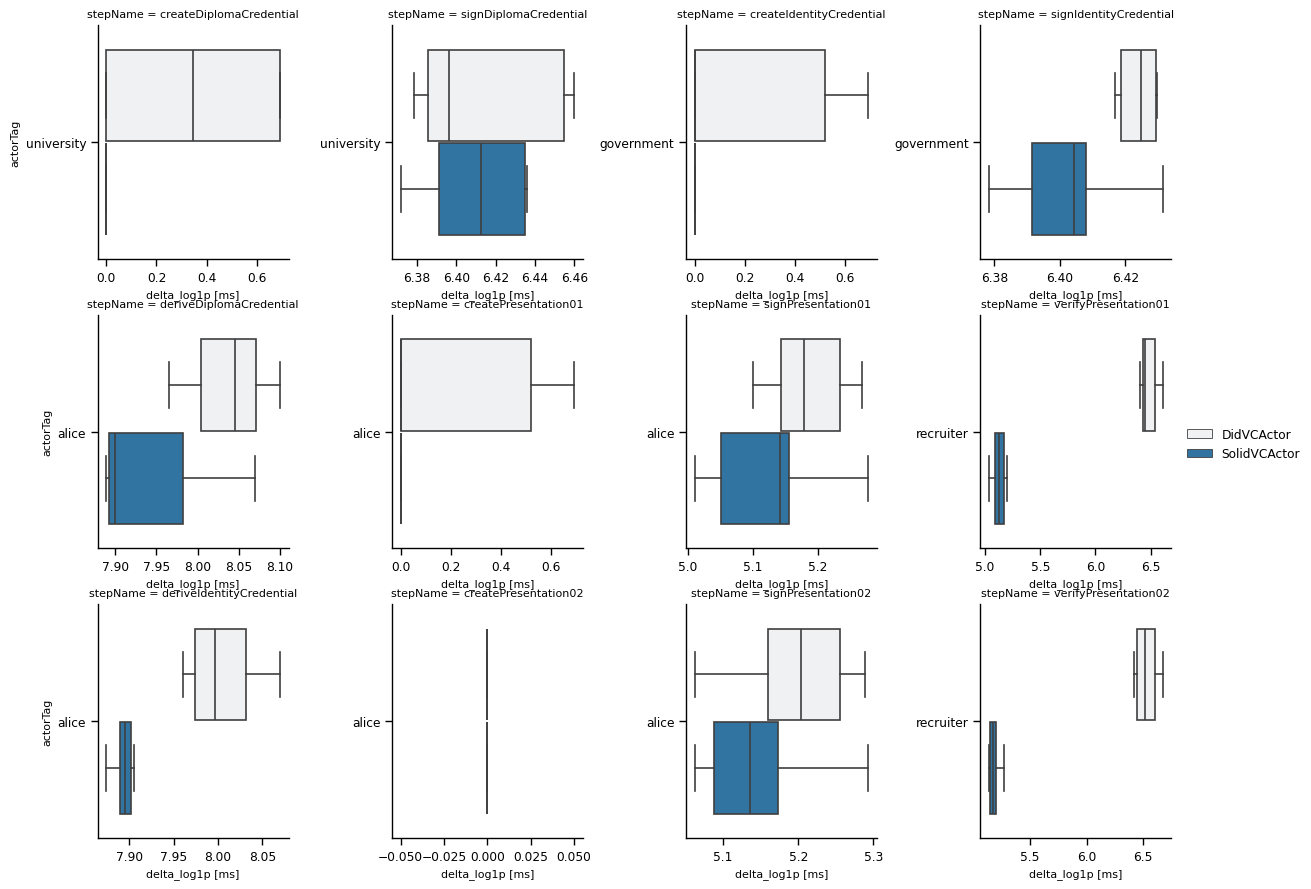

In [248]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

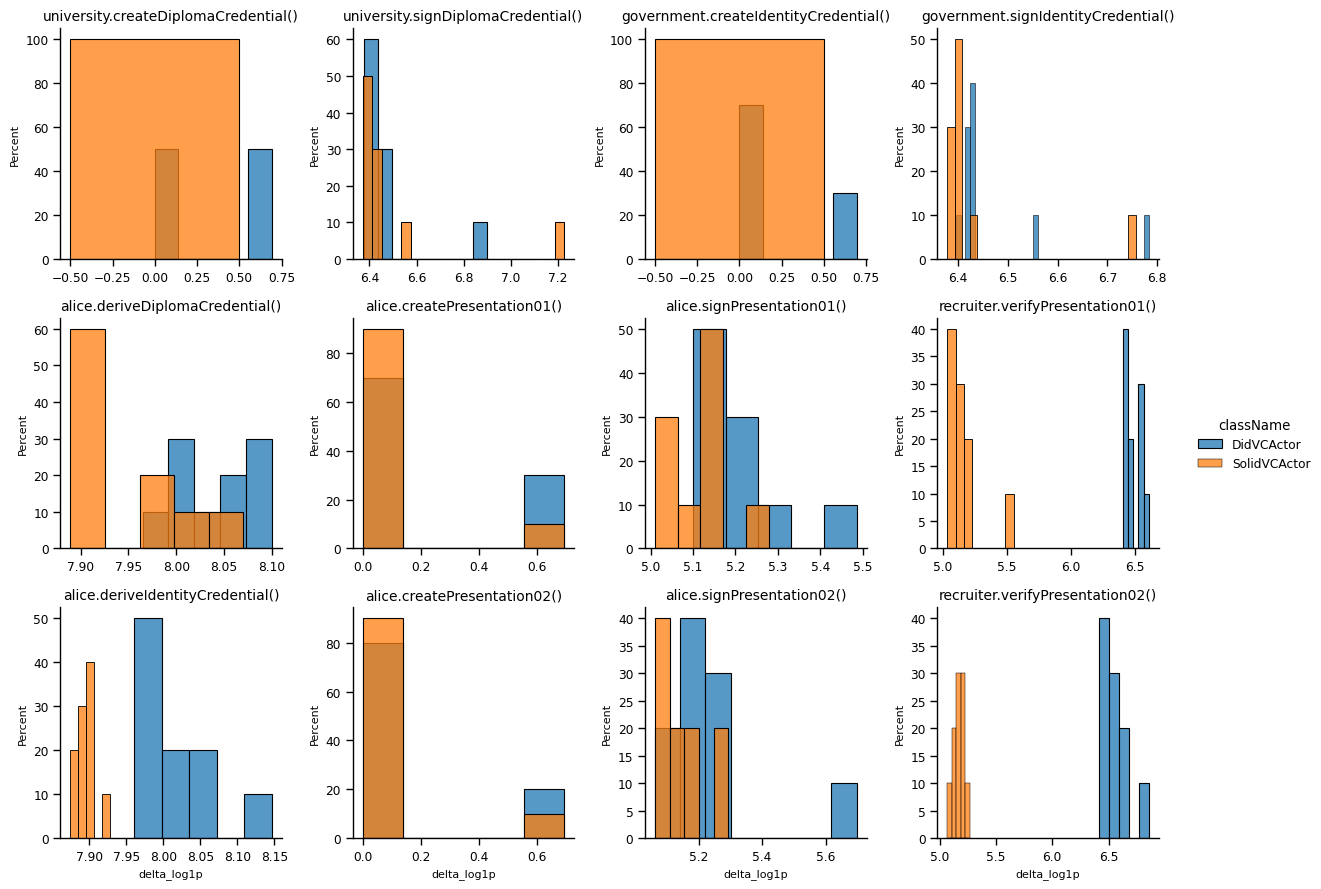

In [250]:
kwargs_fg = dict(col = 'stepName',
                 hue='className',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x=VAR_X,
    stat='percent',
    element='bars',
    discrete=False,
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()
plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'))
plt.show()

---

In [251]:
df_tl.groupby(['phase','actorTag','className','actorStep'])['delta'].agg(['mean']).unstack('className')

mean  \
className                                                     DidVCActor   
phase          actorTag   actorStep                                        
phase-1        alice      alice.createPresentation01                 0.3   
                          alice.deriveDiplomaCredential           3096.8   
                          alice.signPresentation01                 182.6   
               recruiter  recruiter.verifyPresentation01           652.9   
phase-2        alice      alice.createPresentation02                 0.2   
                          alice.deriveIdentityCredential          3025.2   
                          alice.signPresentation02                 191.1   
               recruiter  recruiter.verifyPresentation02           702.9   
pre-evaluation government government.createIdentityCredential        0.3   
                          government.signIdentityCredential        648.7   
               university university.createDiplomaCredential         0.5   
                          university.signDiplomaCredential         645.5   

                                                                            
className                                                     SolidVCActor  
phase          actorTag   actorStep                                         
phase-1        alice      alice.createPresentation01                   0.1  
                          alice.deriveDiplomaCredential             2818.0  
                          alice.signPresentation01                   166.7  
               recruiter  recruiter.verifyPresentation01             175.9  
phase-2        alice      alice.createPresentation02                   0.1  
                          alice.deriveIdentityCredential            2686.3  
                          alice.signPresentation02                   172.1  
               recruiter  recruiter.verifyPresentation02             175.7  
pre-evaluation government government.createIdentityCredential          0.0  
                          government.signIdentityCredential          626.8  
               university university.createDiplomaCredential           0.0  
                          university.signDiplomaCredential           689.1

In [252]:
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

## Statistics

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [253]:
p_thresh = .05

In [254]:
steps = df_tl.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [255]:
grpr_className = df_tl.groupby('className')
assert grpr_className.ngroups == 2
A,B = grpr_className

Reminder

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [256]:
_var = VAR_X
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        assert np.shape(a) == np.shape(b)
        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results


    Group A: DidVCActor
    Group B: SolidVCActor
    Tested variable: delta_log1p



,tvalue,pvalue,df,_alternative,_standard_error,_estimate,REJECT_H0,Conclusion
createDiplomaCredential,3.000000,7.685412e-03,18.0,0.0,0.115525,0.346574,True,"Significant difference in ""delta_log1p"" betwee..."
signDiplomaCredential,-0.422748,6.774867e-01,18.0,0.0,0.096088,-0.040621,False,"No significant difference in ""delta_log1p"" bet..."
createIdentityCredential,1.963961,6.516949e-02,18.0,0.0,0.105880,0.207944,False,"No significant difference in ""delta_log1p"" bet..."
signIdentityCredential,0.650983,5.232820e-01,18.0,0.0,0.051991,0.033845,False,"No significant difference in ""delta_log1p"" bet..."
deriveDiplomaCredential,3.835142,1.212609e-03,18.0,0.0,0.024905,0.095513,True,"Significant difference in ""delta_log1p"" betwee..."
createPresentation01,1.095445,2.877631e-01,18.0,0.0,0.126551,0.138629,False,"No significant difference in ""delta_log1p"" bet..."
signPresentation01,2.022674,5.822117e-02,18.0,0.0,0.043328,0.087639,False,"No significant difference in ""delta_log1p"" bet..."
verifyPresentation01,25.965570,1.020294e-15,18.0,0.0,0.050662,1.315480,True,"Significant difference in ""delta_log1p"" betwee..."
deriveIdentityCredential,6.187609,7.692165e-06,18.0,0.0,0.018958,0.117305,True,"Significant difference in ""delta_log1p"" betwee..."
createPresentation02,0.600000,5.559852e-01,18.0,0.0,0.115525,0.069315,False,"No significant difference in ""delta_log1p"" bet..."


In [257]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(steps_with_sig_diff)

Index(['createDiplomaCredential', 'deriveDiplomaCredential',
       'verifyPresentation01', 'deriveIdentityCredential',
       'verifyPresentation02'],
      dtype='object')


In [258]:
df_tl_sig_diff = df_tl[df_tl.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(100, 18)

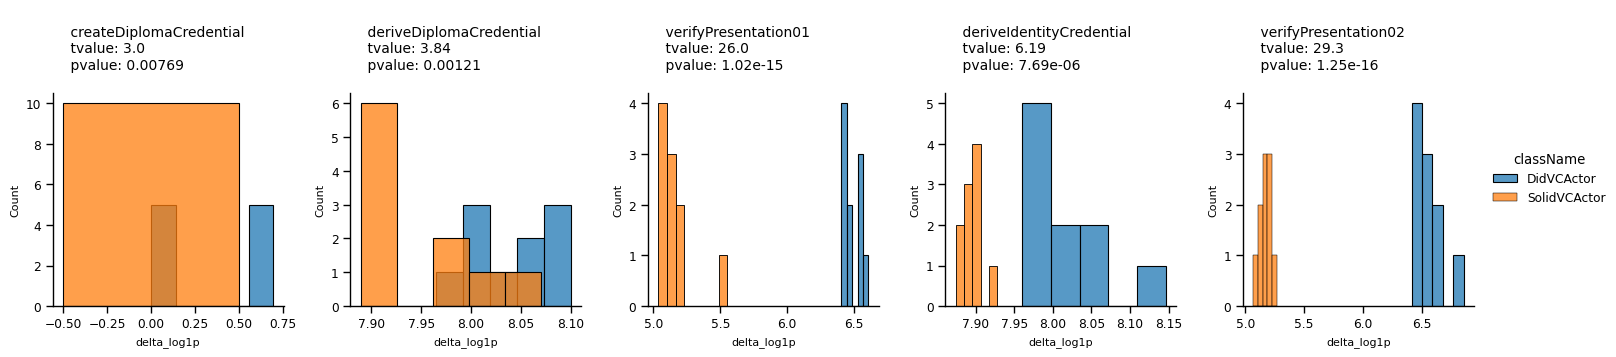

In [259]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False)

g = g.map_dataframe(sns.histplot, x=VAR_X,)
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [260]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [261]:
_var = VAR_X
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        
s_effect_sizes = pd.Series(effect_size_per_step, name=f'cohend_{k_a}_{k_b}')

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
df_effect_sizes

,cohend_DidVCActor_SolidVCActor,effect_class
createDiplomaCredential,1.341641,VERY_LARGE
signDiplomaCredential,-0.189058,VERY_SMALL
createIdentityCredential,0.878310,LARGE
signIdentityCredential,0.291128,SMALL
deriveDiplomaCredential,1.715127,VERY_LARGE
createPresentation01,0.489898,SMALL
signPresentation01,0.904567,LARGE
verifyPresentation01,11.612156,HUGE
deriveIdentityCredential,2.767183,HUGE
createPresentation02,0.268328,SMALL


In [262]:
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))

# Appendix

## Statsmodels

In [42]:
?stats.ttest_ind

Signature:
stats.ttest_ind(
    a,
    b,
    axis=0,
    equal_var=True,
    nan_policy='propagate',
    permutations=None,
    random_state=None,
    alternative='two-sided',
    trim=0,
    *,
    keepdims=False,
)
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
equal_var : bool, optional
    If True (default), pe